In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d

p0 = 101325
T0 = 300
phi = 0.7 # equivalence ratio
alpha = 0.6
width = 0.02 # 2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

In [2]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0] #Sl0
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [3]:
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame) # laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1]

Adiabatic temperature (Tad) from FreeFlame: 1820.61 K


In [4]:
cp = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_ = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

In [5]:
def calculate_heat_loss_coefficient(Tp, Tad, Tr):
    beta = (Tp - Tr) / (Tad - Tr)
    return beta

In [6]:
Tp = [605, 909, 1213, 1517] #beta 0.2, 0.4, 0.6, 0.8
for temp in Tp:
    beta = calculate_heat_loss_coefficient(temp, Tad, T0)
    print(f'{beta:.1f}')

0.2
0.4
0.6
0.8


In [7]:
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    return S_cF

In [39]:
mdot_values = np.logspace(-2, 2, 100)  # From 0.01 to 100 with 100 points
Ka1_values = []
ScF1_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tp  # beta=0.2
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 605 # beta=0.2
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka1_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF1_values.append(ScF)

print(Ka1_values)
print(ScF1_values)

[0.0016734670101391021, 0.0017353637410183183, 0.0022870990023536692, 0.002850714682045305, 0.0035090168339713687, 0.004284900945530291, 0.005194751357196241, 0.006259579500505982, 0.007513249778334362, 0.0092564746703561, 0.011029752670251554, 0.013105097961635242, 0.015518251809668865, 0.018319964921496446, 0.02155359309357879, 0.025289470163722103, 0.029585826075231594, 0.034527390406243315, 0.04016723315399465, 0.04660359038902699, 0.053938919821059556, 0.06222499040743416, 0.07155551077283062, 0.084660872256915, 0.09857426264029237, 0.1158047807048331, 0.13597065494516772, 0.1593688708972552, 0.18651744582673582, 0.21792936248365585, 0.2542202147904929, 0.29614470640727, 0.014296492775362008, 0.015758121905853517, 0.017356440730801136, 0.019132463731565526, 0.021112238452178748, 0.023283647855560252, 0.02566533718149298, 0.02827869944387197, 0.031154110808521148, 0.03434088713532089, 0.03782026747281166, 0.04163242456800028, 0.04580184578061076, 0.05046676653444171, 0.055577738820

In [40]:
y1_values = []
for i in ScF1_values:
    temp = i / flame_speed
    y1_values.append(temp)
print(y1_values)

[0.03341501993452775, 0.03472790985700506, 0.04001040510566725, 0.045002277333800585, 0.05022029801194629, 0.055726280688114034, 0.061551486587787425, 0.0677654352299268, 0.07433734519046652, 0.08200155049410002, 0.08959805934774369, 0.09776897621080483, 0.10654792266795553, 0.11596314650792322, 0.12598316932205275, 0.1367428744940803, 0.1483021593731081, 0.16068729943848745, 0.1738342517778189, 0.18795208605963226, 0.20303299465056984, 0.21919327874364905, 0.23637963365775438, 0.25705150281950806, 0.27699603034547315, 0.2984554051233749, 0.32149509879636434, 0.34597828105132944, 0.3720920185731973, 0.3999994121600083, 0.429669832097499, 0.4614313227399067, 4.684872012768651e-06, 4.903649209795964e-06, 5.149639960182642e-06, 5.420777483021801e-06, 5.716201265694223e-06, 6.050178055051121e-06, 6.3964707510759034e-06, 6.754561337467671e-06, 7.139967017543304e-06, 7.544574950549545e-06, 7.96718186828042e-06, 8.42364155718538e-06, 8.880154217670944e-06, 9.3956614533909e-06, 9.9622268560918

In [44]:
mdot_values = np.logspace(-2, 2, 100)  # From 0.01 to 100 with 100 points
Ka2_values = []
ScF2_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf2 = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf2.transport_model = 'multicomponent'
    flame_cf2.energy_enabled = True
    flame.soret_enabled = True
    flame_cf2.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf2.reactants.mdot = mdot
    flame_cf2.products.mdot = mdot
    flame_cf2.products.T = Tp  # beta=0.4
    flame_cf2.products.X = Xflame
    flame_cf2.set_initial_guess(equilibrate=False)
    
    flame_cf2.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 909 # beta=0.4
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf2.velocity, flame_cf2.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka2_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf2, gas, ['CH4', 'H2'])
    ScF2_values.append(ScF)

print(Ka2_values)
print(ScF2_values)

[0.001319458029503298, 0.002120705692634718, 0.0025771304008546272, 0.0031192527716023028, 0.0037593164180056435, 0.0045164466088012285, 0.00540830278353772, 0.006456178688402562, 0.007690848401827364, 0.009425134908953355, 0.0111824617162207, 0.013238914197615147, 0.01563277957044329, 0.018415722960317873, 0.021630774509300194, 0.025352164625518276, 0.029636491992134088, 0.03456937069554475, 0.04020986751958261, 0.046635495589118336, 0.05397181566785334, 0.06226099208025205, 0.07159679209721205, 0.08473024421640021, 0.09841019595594602, 0.11562678367069311, 0.13577225540002508, 0.15914675469708947, 0.18628224784919387, 0.2176813680781372, 0.2539411920874552, 0.2958492373499432, 0.3440099299236088, 0.40277590044962985, 0.024537605834686855, 0.027068661814066922, 0.029803803848715605, 0.03281788521117946, 0.036204919145560184, 0.039907385946180034, 0.04396166192921858, 0.04837389541900431, 0.05317814509497609, 0.05847138744614414, 0.06461894981963978, 0.07118702948371813, 0.078349432859

In [45]:
y2_values = []
for i in ScF2_values:
    temp = i / flame_speed
    y2_values.append(temp)
print(y2_values)

[0.029733496464438104, 0.0377553760549373, 0.04203805684233688, 0.046625085526899486, 0.051505851151123376, 0.056738496536118475, 0.06235402458136392, 0.06839826043077163, 0.07480880571705756, 0.08233641782603073, 0.08982862652937537, 0.09794587206081837, 0.10662927678744571, 0.11597586927109371, 0.12594214919204752, 0.1366656340596336, 0.14819822513870368, 0.16056738886883415, 0.1737145681499642, 0.18781813845441403, 0.202900824677761, 0.21906270322864846, 0.23625464692952902, 0.25693957677843415, 0.27688135163519756, 0.29834305435306613, 0.321384153238565, 0.34586805549028654, 0.3719819630390208, 0.3998893253444411, 0.42955708096514056, 0.46131484209566354, 0.49481590897081085, 0.5331169512491722, 1.6273534172326318e-05, 1.7015232884694397e-05, 1.8023543146069255e-05, 1.912691366204494e-05, 2.0364498983011702e-05, 2.172055584659703e-05, 2.3266803484692185e-05, 2.485609335862881e-05, 2.6600178195109912e-05, 2.844600718692674e-05, 3.0377633830932622e-05, 3.252534430381464e-05, 3.481158

In [46]:
mdot_values = np.logspace(-2, 2, 100)  # From 0.01 to 100 with 100 points
Ka3_values = []
ScF3_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tp # beta=0.6
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 1213 # beta=0.6
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka3_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF3_values.append(ScF)
    
print(Ka3_values)
print(ScF3_values)

[0.0016734670101391021, 0.002532072543501373, 0.002986094812389616, 0.0035224127125849047, 0.004155220641805998, 0.004903652619542243, 0.0057847328242507405, 0.007021278050200706, 0.00828661930877391, 0.00976790102996653, 0.011507402024380758, 0.013537591957367536, 0.015903276001646097, 0.018659257150416185, 0.021852796094084304, 0.025546160700332533, 0.029804933107800878, 0.03471567296057943, 0.040328823397715007, 0.04673726002032646, 0.0540590690111093, 0.06234320685123513, 0.07166727515126137, 0.0848038377802556, 0.09826304195635664, 0.11546274253892283, 0.13558625876473582, 0.15894700911038695, 0.18605911832321284, 0.21746554416229746, 0.25367464635007947, 0.29558524003287595, 0.343694144907997, 0.40244473733804687, 0.46696452611363326, 0.5398953760328671, 0.619695461725769, 0.7140420018722087, 0.8219576560094713, 0.9370082406202977, 1.0130918175105337, 1.0209400502996444, 1.0215022583604598, 1.0002726334208254, 1.007156278150477, 1.0158403022958113, 1.0143945483675259, 1.025231164

In [47]:
y3_values = []
for i in ScF3_values:
    temp = i / flame_speed
    y3_values.append(temp)
print(y3_values)

[0.03341501993452775, 0.04119262485492518, 0.04505109580363577, 0.049247926767082416, 0.05379993546302116, 0.058727792188440604, 0.06401965805524014, 0.07024750708158974, 0.0765059925384408, 0.08331228290142455, 0.09065908650826121, 0.09858933261276064, 0.1071399748975154, 0.11631677645547993, 0.12621695681914052, 0.13686830506882838, 0.14832434565504068, 0.16058617890773377, 0.17372455021697797, 0.1877926768879728, 0.20284951359708503, 0.21901378836084323, 0.23617531262681454, 0.25685750809466307, 0.27679627057665024, 0.29825854210280495, 0.3212967976150642, 0.34577960780417416, 0.3718917476140516, 0.39980208380620263, 0.42946452419696435, 0.4612092132850658, 0.49471290899917914, 0.5330140583082119, 0.5713221332369459, 0.6108519629815988, 0.6500644572043279, 0.6941319200250217, 0.7389411345544092, 0.7777817117507317, 0.7864176846284553, 0.7911401209847255, 0.7930878062503468, 0.7856570211262364, 0.7905814674364957, 0.7957431301921081, 0.7974319645126461, 0.8041137283520639, 0.80593502

In [48]:
mdot_values = np.logspace(-2, 2, 100)  # From 0.01 to 100 with 100 points
Ka4_values = []
ScF4_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tp  # beta=0.8
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 1517 # beta=0.8
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka4_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF4_values.append(ScF)

print(Ka4_values)
print(ScF4_values)

[0.002146796117206929, 0.0029983448356444404, 0.0034679023077742173, 0.004017416322407892, 0.004661386998213138, 0.005568425832658812, 0.006481711306077262, 0.007549894971549075, 0.008806506568908608, 0.01027580495985137, 0.01199150853475691, 0.013996094002551446, 0.016333357348800724, 0.01905445626442839, 0.022207504472413257, 0.025861486035125714, 0.03008384880726804, 0.03495429409917445, 0.040533599085470204, 0.04691172336224479, 0.0542057814422311, 0.06246597613385026, 0.07177575574585497, 0.08490273803606271, 0.09813380459988286, 0.11530931871667247, 0.13540961453574776, 0.15875736793391715, 0.18584763051107836, 0.21721532509419744, 0.25342318137397357, 0.29530489761668854, 0.34339662519116587, 0.40213028331172274, 0.46661286332317253, 0.5395059630455, 0.6192381127312191, 0.7134547301323995, 0.821218098625007, 0.9364969921888262, 1.0176785789524547, 1.0212643136108097, 0.9933567955203974, 0.9988826796282406, 1.0141172831434622, 1.0135840275092327, 1.0197936543143984, 1.01592261854

In [49]:
y4_values = []
for i in ScF4_values:
    temp = i / flame_speed
    y4_values.append(temp)
print(y4_values)

[0.037664943146954684, 0.0450916350913276, 0.04866113712454633, 0.05247986461884454, 0.056795342494047905, 0.0617623313220911, 0.06685955441003587, 0.07240905905785185, 0.07841540860623172, 0.08495299784414803, 0.09206702495601063, 0.09973131917345063, 0.10806471872056998, 0.11710295089899712, 0.1268362094855151, 0.13733605741493038, 0.14868911895153783, 0.16083415769449041, 0.1739222427514964, 0.1878863416224138, 0.20288835114923187, 0.21901301394914485, 0.23615595515798693, 0.2568211625420708, 0.2767525090825404, 0.29820265599195334, 0.32123549127937734, 0.3457189747766681, 0.3718313181470345, 0.3998460721803658, 0.42940270149875603, 0.46115290809471265, 0.4946513644130957, 0.5329724296477244, 0.5712764059889558, 0.6107992949978488, 0.6499954256296824, 0.6940253615141442, 0.7388405129026626, 0.7770770969929706, 0.7891480054374018, 0.7919658143423671, 0.7817138478033875, 0.7860611882481413, 0.7942276184744226, 0.7959795092619175, 0.8005882193351029, 0.801265739646615, 0.80806261738448

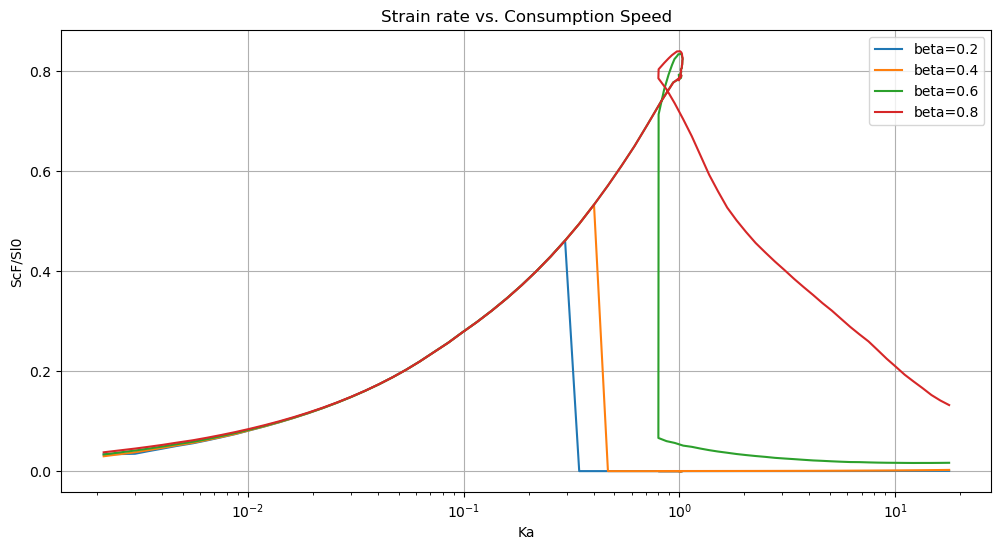

In [69]:
plt.figure(figsize=(12, 6))

plt.plot(Ka4_values, y1_values, label='beta=0.2')
plt.plot(Ka4_values, y2_values, label='beta=0.4')
plt.plot(Ka4_values, y3_values, label='beta=0.6')
plt.plot(Ka4_values, y4_values, label='beta=0.8')

# 그래프 설정
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('ScF/Sl0')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.legend()
plt.show()

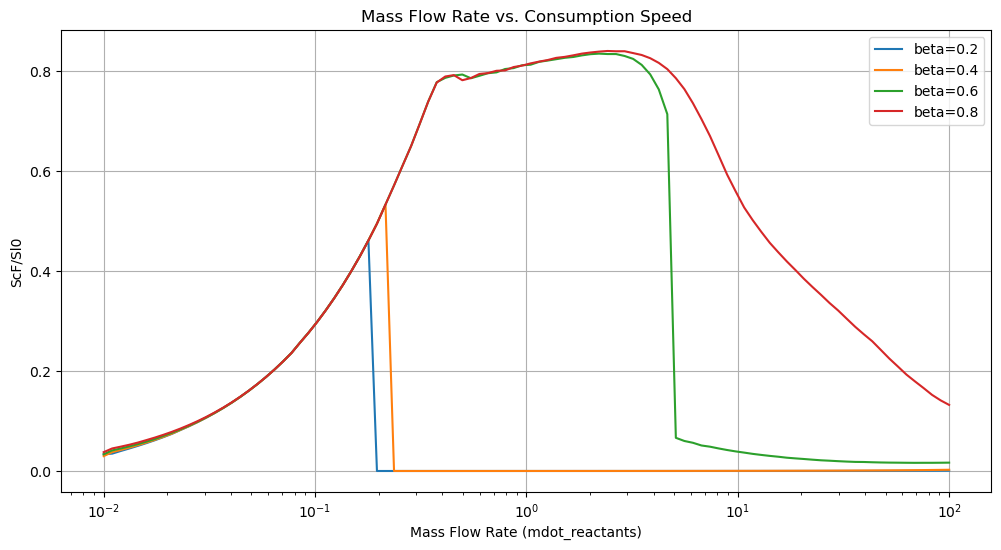

In [58]:
plt.figure(figsize=(12, 6))

plt.plot(mdot_values, y1_values, label='beta=0.2')
plt.plot(mdot_values, y2_values, label='beta=0.4')
plt.plot(mdot_values, y3_values, label='beta=0.6')
plt.plot(mdot_values, y4_values, label='beta=0.8')

# 그래프 설정
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('ScF/Sl0')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.legend()
plt.show()

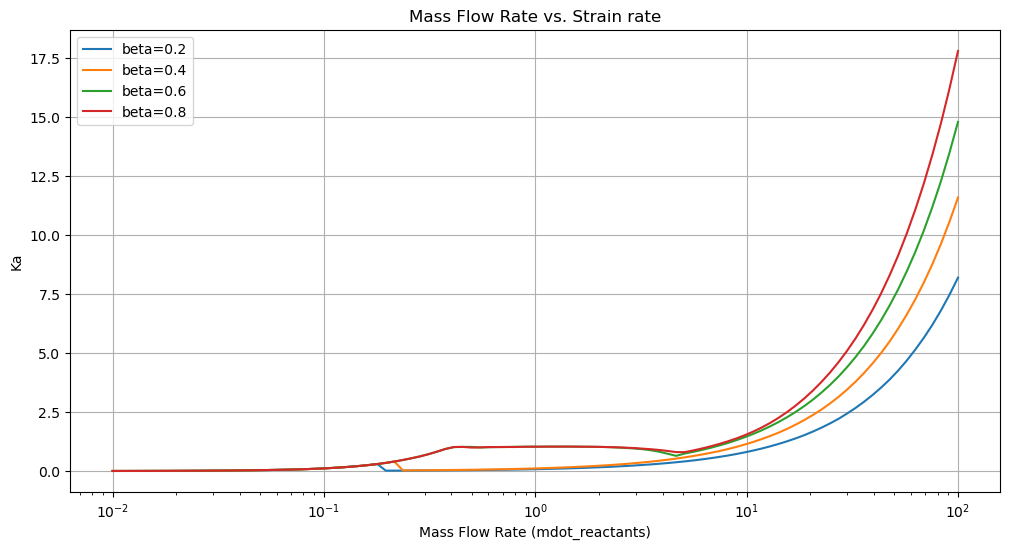

In [59]:
plt.figure(figsize=(12, 6))

plt.plot(mdot_values, Ka1_values, label='beta=0.2')
plt.plot(mdot_values, Ka2_values, label='beta=0.4')
plt.plot(mdot_values, Ka3_values, label='beta=0.6')
plt.plot(mdot_values, Ka4_values, label='beta=0.8')

# 그래프 설정
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('Ka')
plt.title('Mass Flow Rate vs. Strain rate')
plt.grid(True)
plt.legend()
plt.show()